In [1]:
!mkdir -p /data/coco/

# Download the annotation ZIP and extract it, then remove the ZIP file
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip -q annotations_trainval2017.zip -d /data/coco/
!rm annotations_trainval2017.zip

# Download the train2017 ZIP, extract it, and remove the ZIP file
!wget http://images.cocodataset.org/zips/train2017.zip
!unzip -q train2017.zip -d /data/coco/
!rm train2017.zip

# Download the val2017 ZIP, extract it, and remove the ZIP file
!wget http://images.cocodataset.org/zips/val2017.zip
!unzip -q val2017.zip -d /data/coco/
!rm val2017.zip

# Create test dataset
!mkdir -p /data/coco/test2017
!cp -r /data/coco/val2017/* /data/coco/test2017/

--2024-08-23 06:25:13--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 54.231.165.25, 3.5.8.187, 3.5.7.115, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|54.231.165.25|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  93.3MB/s    in 2.6s    

2024-08-23 06:25:16 (93.3 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

--2024-08-23 06:25:33--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.20.52, 52.217.135.81, 54.231.204.1, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.20.52|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zi

In [1]:
!pip install super-gradients
!pip install pybboxes
!git clone https://github.com/Jozefov/mAP.git
!git clone https://github.com/immersive-limit/coco-manager.git

fatal: destination path 'mAP' already exists and is not an empty directory.
fatal: destination path 'coco-manager' already exists and is not an empty directory.


In [2]:
import json
import os
from PIL import Image
import pybboxes as pbx
import yaml
import shutil
import random
from collections import Counter
import cv2

In [14]:
# all COCO classes
with open('/data/coco/annotations/instances_val2017.json', 'r') as f:
    data = json.load(f)

categories = data['categories']
category_id_to_name = {category['id']: category['name'] for category in categories}

categories_list = []
for category_id, category_name in category_id_to_name.items():
    print(f"ID: {category_id}, Name: {category_name}")
    categories_list.append(category_name)

ID: 1, Name: person
ID: 2, Name: bicycle
ID: 3, Name: car
ID: 4, Name: motorcycle
ID: 5, Name: airplane
ID: 6, Name: bus
ID: 7, Name: train
ID: 8, Name: truck
ID: 9, Name: boat
ID: 10, Name: traffic light
ID: 11, Name: fire hydrant
ID: 13, Name: stop sign
ID: 14, Name: parking meter
ID: 15, Name: bench
ID: 16, Name: bird
ID: 17, Name: cat
ID: 18, Name: dog
ID: 19, Name: horse
ID: 20, Name: sheep
ID: 21, Name: cow
ID: 22, Name: elephant
ID: 23, Name: bear
ID: 24, Name: zebra
ID: 25, Name: giraffe
ID: 27, Name: backpack
ID: 28, Name: umbrella
ID: 31, Name: handbag
ID: 32, Name: tie
ID: 33, Name: suitcase
ID: 34, Name: frisbee
ID: 35, Name: skis
ID: 36, Name: snowboard
ID: 37, Name: sports ball
ID: 38, Name: kite
ID: 39, Name: baseball bat
ID: 40, Name: baseball glove
ID: 41, Name: skateboard
ID: 42, Name: surfboard
ID: 43, Name: tennis racket
ID: 44, Name: bottle
ID: 46, Name: wine glass
ID: 47, Name: cup
ID: 48, Name: fork
ID: 49, Name: knife
ID: 50, Name: spoon
ID: 51, Name: bowl
ID: 5

In [6]:
categories_list

['person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'couch',
 'potted plant',
 'bed',
 'dining table',
 'toilet',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

In [3]:
def filter_coco_dataset(annotations_file):
    """
    Filters a COCO dataset based on the images that have annotations.

    Parameters:
    - annotations_file (str): Path to the COCO annotations JSON file.

    Returns:
    - filtered_dataset (dict): A dictionary containing filtered 'images', 'annotations', and 'categories' lists.
    """
    with open(annotations_file, 'r') as f:
        coco_data = json.load(f)

    # Get a set of image IDs that have annotations
    filtered_image_ids = {annotation['image_id'] for annotation in coco_data['annotations']}

    # Filter the images that have corresponding annotations
    filtered_images = [image for image in coco_data['images'] if image['id'] in filtered_image_ids]

    print(f"Are images from annotation and images same size? {len(filtered_image_ids) == len(filtered_images)}")

    filtered_dataset = {
        'images': filtered_images,
        'annotations': coco_data['annotations'],
        'categories': coco_data['categories']
    }

    return filtered_dataset

In [4]:

annotations_file_train = '/data/coco/annotations/instances_train2017.json'
filtered_dataset_train = filter_coco_dataset(annotations_file_train)

annotations_file_validation = '/data/coco/annotations/instances_val2017.json'
filtered_dataset_validation = filter_coco_dataset(annotations_file_validation)

annotations_file_test = '/data/coco/annotations/instances_val2017.json'
filtered_dataset_test = filter_coco_dataset(annotations_file_test)

Are images from annotation and images same size? True
Are images from annotation and images same size? True
Are images from annotation and images same size? True


In [5]:
def remove_unlisted_images(image_dir, filtered_dataset):
    """
    Removes all images from the specified directory that are not listed in the filtered dataset (after class filtration).

    Parameters:
    - image_dir (str): The directory containing the images to be filtered.
    - filtered_dataset (dict): Dictionary containing filtered 'images', 'annotations', and 'categories'.

    Description:
    This function scans the provided image directory and removes any image files that are not
    present in the `filtered_dataset['images']` list.
    """

    retained_images = {image_info['file_name'] for image_info in filtered_dataset['images']}

    all_images = set(os.listdir(image_dir))

    unlisted_images = all_images - retained_images

    for image_filename in unlisted_images:
        image_path = os.path.join(image_dir, image_filename)
        os.remove(image_path)

    print(f"Cleanup complete. {len(unlisted_images)} unlisted images have been removed.")



In [6]:
# Remove unlisted images
remove_unlisted_images("/data/coco/train2017", filtered_dataset_train)

remove_unlisted_images("/data/coco/val2017", filtered_dataset_validation)

remove_unlisted_images("/data/coco/test2017", filtered_dataset_test)

Cleanup complete. 1021 unlisted images have been removed.
Cleanup complete. 48 unlisted images have been removed.
Cleanup complete. 48 unlisted images have been removed.


In [8]:
def coco_to_yolo(coco_annotation_path, images_dir, output_dir, log_file_path=None, yaml_output_path=None):
    """
    Converts COCO format annotations to YOLO format and generates a YAML file describing the dataset.

    Parameters:
    - coco_annotation_path (str): Path to the COCO annotation JSON file.
    - images_dir (str): Directory containing the images referenced in the COCO annotations.
    - output_dir (str): Directory where YOLO format annotation files will be saved.
    - log_file_path (str, optional): Path to save log of images with wrong annotation.
    - yaml_output_path (str, optional): Path to save the generated YAML file. If None, it will save in the `output_dir`.

    Description:
    This function reads annotations from a COCO format JSON file and converts them to the YOLO format.
    It also generates a `data.yaml` file that describes the dataset.
    In YOLO format, each image has a corresponding .txt file containing the bounding box annotations.
    Each line in the .txt file follows the format:

    class_id center_x center_y width height

    Where:
    - `class_id` is the ID of the object class (starting from 0).
    - `center_x`, `center_y` are the normalized coordinates of the bounding box center.
    - `width`, `height` are the normalized dimensions of the bounding box.

    The coordinates and dimensions are normalized with respect to the image width and height.

    The function processes each annotation in the COCO dataset, converts the bounding box to YOLO format
    using the `pybboxes` library, and saves the results in a .txt file named after the corresponding image.

    """

    count_wrong_size = 0

    with open(coco_annotation_path, 'r') as f:
        coco_data = json.load(f)

    class_names = [category['name'] for category in coco_data['categories']]

    os.makedirs(output_dir, exist_ok=True)

    category_id_to_yolo_id = {category['id']: idx for idx, category in enumerate(coco_data['categories'])}

    # Process each annotation
    for annotation in coco_data['annotations']:
        image_id = annotation['image_id']
        category_id = annotation['category_id']
        bbox = annotation['bbox']

        # Get image file name and size
        image_info = next(image for image in coco_data['images'] if image['id'] == image_id)
        image_filename = image_info['file_name']
        image_path = os.path.join(images_dir, image_filename)

        if not os.path.exists(image_path):
            print(f"Warning: Label file not found for image: {image_path}")
            continue

        with Image.open(image_path) as img:
            image_size = img.size  # (width, height)

        try:
            yolo_bbox = pbx.convert_bbox(bbox, from_type="coco", to_type="yolo", image_size=image_size)
        except Exception as e:
            if log_file_path is not None:
                with open(log_file_path, 'a') as log_file:
                    log_file.write(f"{count_wrong_size}: Error processing image {image_filename}: {str(e)}\n")
            count_wrong_size+=1
            continue

        yolo_class_id = category_id_to_yolo_id[category_id]

        yolo_annotation_line = f"{yolo_class_id} {' '.join(map(str, yolo_bbox))}\n"

        yolo_annotation_file = os.path.join(output_dir, f"{os.path.splitext(image_filename)[0]}.txt")

        with open(yolo_annotation_file, 'a') as yolo_file:
            yolo_file.write(yolo_annotation_line)

    yaml_content = {
        'nc': len(class_names),                     # Number of classes
        'names': class_names                        # List of class names
    }

    # Determine where to save the YAML file
    if yaml_output_path is None:
        yaml_output_path = os.path.join(output_dir, 'data.yaml')

    # Save the YAML file
    with open(yaml_output_path, 'w') as yaml_file:
        yaml.dump(yaml_content, yaml_file)

    print(f"Wrong annotation for {count_wrong_size} images")

    print(f"YOLO annotations and data.yaml have been saved to {output_dir}")

In [9]:
# clean folders
!rm -r /data/coco/annotations/yolo_format_validation/
!rm -r /data/coco/annotations/yolo_format_test/
!rm -r /data/coco/annotations/yolo_format_train/

rm: cannot remove '/data/coco/annotations/yolo_format_validation/': No such file or directory
rm: cannot remove '/data/coco/annotations/yolo_format_test/': No such file or directory
rm: cannot remove '/data/coco/annotations/yolo_format_train/': No such file or directory


In [11]:
# converting validation dataset to yolo format
coco_to_yolo(
    coco_annotation_path='/data/coco/annotations/instances_train2017.json',
    images_dir='/data/coco/train2017',
    output_dir='/data/coco/annotations/yolo_format_train/',
    log_file_path='/content/error_log_train.txt',
    yaml_output_path= '/data/coco/data_train.yaml',
)

coco_to_yolo(
    coco_annotation_path='/data/coco/annotations/instances_val2017.json',
    images_dir='/data/coco/val2017',
    output_dir='/data/coco/annotations/yolo_format_validation/',
    log_file_path='/content/error_log_validation.txt',
    yaml_output_path= '/data/coco/data_validaiton.yaml',
)

coco_to_yolo(
    coco_annotation_path='/data/coco/annotations/instances_val2017.json',
    images_dir='/data/coco/test2017',
    output_dir='/data/coco/annotations/yolo_format_test/',
    log_file_path='/content/error_log_test.txt',
    yaml_output_path= '/data/coco/data_test.yaml',
)

Wrong annotation for 0 images
YOLO annotations and data.yaml have been saved to /data/coco/annotations/yolo_format_validation/
Wrong annotation for 0 images
YOLO annotations and data.yaml have been saved to /data/coco/annotations/yolo_format_test/


In [12]:
def organize_dataset_folders(input_folders, dataset_params, move_files=False):
    """
    Organize dataset folders for training, validation, and test sets with images and labels,
    and move or copy the dataset YAML file.

    Parameters:
    - input_folders (dict): Dictionary containing paths to 'train_images', 'train_labels',
                            'val_images', 'val_labels', 'test_images', 'test_labels', 'dataset_yaml'.
    - dataset_params (dict): Dictionary defining the dataset structure and paths.
    - move_files (bool): Whether to move folders and YAML file instead of copying.

    Description:
    This function moves or copies the contents of the provided folders containing images and labels
    into the designated directory structure as defined in `dataset_params`, and moves or copies
    the dataset YAML file to the root of the dataset directory.
    """

    # Create all necessary directories in the dataset_params structure
    for dir_path in [dataset_params['train_images_dir'], dataset_params['train_labels_dir'],
                     dataset_params['val_images_dir'], dataset_params['val_labels_dir'],
                     dataset_params['test_images_dir'], dataset_params['test_labels_dir']]:
        full_path = os.path.join(dataset_params['data_dir'], dir_path)
        os.makedirs(full_path, exist_ok=True)

    def move_or_copy_folder(src_folder, dest_folder):
        if not os.path.exists(src_folder):
            print(f"Source folder {src_folder} does not exist. Skipping.")
            return

        # Ensure the destination folder exists
        os.makedirs(dest_folder, exist_ok=True)

        # Move or copy the contents of the folder, not the folder itself
        for item in os.listdir(src_folder):
            s = os.path.join(src_folder, item)
            d = os.path.join(dest_folder, item)
            if move_files:
                shutil.move(s, d)
            else:
                if os.path.isdir(s):
                    shutil.copytree(s, d)
                else:
                    shutil.copy2(s, d)

    # Process each set
    move_or_copy_folder(input_folders['train_images'], os.path.join(dataset_params['data_dir'], dataset_params['train_images_dir']))
    move_or_copy_folder(input_folders['train_labels'], os.path.join(dataset_params['data_dir'], dataset_params['train_labels_dir']))
    move_or_copy_folder(input_folders['val_images'], os.path.join(dataset_params['data_dir'], dataset_params['val_images_dir']))
    move_or_copy_folder(input_folders['val_labels'], os.path.join(dataset_params['data_dir'], dataset_params['val_labels_dir']))
    move_or_copy_folder(input_folders['test_images'], os.path.join(dataset_params['data_dir'], dataset_params['test_images_dir']))
    move_or_copy_folder(input_folders['test_labels'], os.path.join(dataset_params['data_dir'], dataset_params['test_labels_dir']))

    # Move or copy the dataset YAML file
    dataset_yaml_src = input_folders.get('dataset_yaml')
    if dataset_yaml_src and os.path.exists(dataset_yaml_src):
        dataset_yaml_dest = os.path.join(dataset_params['data_dir'], os.path.basename(dataset_yaml_src))
        if move_files:
            shutil.move(dataset_yaml_src, dataset_yaml_dest)
        else:
            shutil.copy(dataset_yaml_src, dataset_yaml_dest)
        print(f"Dataset YAML file moved/copied to {dataset_yaml_dest}")
    else:
        print("No dataset YAML file found or specified.")

    print(f"Dataset organized in {dataset_params['data_dir']} with train/val/test folders.")


In [24]:
# Here images from validation and test are same
input_folders = {
    'train_images': '/data/coco/train2017',
    'train_labels': '/data/coco/annotations/yolo_format_train',
    'val_images': '/data/coco/val2017',
    'val_labels': '/data/coco/annotations/yolo_format_validation',
    'test_images': '/data/coco/test2017',
    'test_labels': '/data/coco/annotations/yolo_format_test',
    'dataset_yaml': '/data/coco/data.yaml'
}

dataset_params = {
    'data_dir': '/content/dataset_train',
    'train_images_dir': 'train/images',
    'train_labels_dir': 'train/labels',
    'val_images_dir': 'valid/images',
    'val_labels_dir': 'valid/labels',
    'test_images_dir': 'test/images',
    'test_labels_dir': 'test/labels',
    'classes': categories_list
}


In [16]:
organize_dataset_folders(input_folders, dataset_params, move_files=True)

No dataset YAML file found or specified.
Dataset organized in /content/dataset_train with train/val/test folders.


## Test

In [25]:

def check_image_label_pairs(images_dir, labels_dir):
    """
    Checks if each image in the images_dir has a corresponding label file in the labels_dir.
    Both directories are expected to have the same structure and file names, differing only by extension.

    Parameters:
    - images_dir (str): Directory containing image files (.jpg).
    - labels_dir (str): Directory containing label files (.txt).

    Returns:
    - missing_labels (list): List of image files without corresponding label files.
    - extra_labels (list): List of label files without corresponding image files.
    """

    # Get a list of image files (without extensions)
    image_files = {os.path.splitext(f)[0] for f in os.listdir(images_dir) if f.endswith('.jpg')}

    # Get a list of label files (without extensions)
    label_files = {os.path.splitext(f)[0] for f in os.listdir(labels_dir) if f.endswith('.txt')}

    # Find images without labels
    missing_labels = image_files - label_files

    # Find labels without images
    extra_labels = label_files - image_files

    return missing_labels, extra_labels

def test_dataset_integrity(dataset_params):
    """
    Tests the integrity of the dataset by checking if every image has a corresponding label file.

    Parameters:
    - dataset_params (dict): Dictionary defining the dataset structure and paths.
    """

    # Check train set
    train_missing_labels, train_extra_labels = check_image_label_pairs(
        os.path.join(dataset_params['data_dir'], dataset_params['train_images_dir']),
        os.path.join(dataset_params['data_dir'], dataset_params['train_labels_dir'])
    )
    assert len(train_missing_labels) == 0, f"Missing labels for train images: {train_missing_labels}"
    assert len(train_extra_labels) == 0, f"Extra labels found in train set: {train_extra_labels}"

    # Check validation set
    val_missing_labels, val_extra_labels = check_image_label_pairs(
        os.path.join(dataset_params['data_dir'], dataset_params['val_images_dir']),
        os.path.join(dataset_params['data_dir'], dataset_params['val_labels_dir'])
    )
    assert len(val_missing_labels) == 0, f"Missing labels for validation images: {val_missing_labels}"
    assert len(val_extra_labels) == 0, f"Extra labels found in validation set: {val_extra_labels}"

    # Check test set
    test_missing_labels, test_extra_labels = check_image_label_pairs(
        os.path.join(dataset_params['data_dir'], dataset_params['test_images_dir']),
        os.path.join(dataset_params['data_dir'], dataset_params['test_labels_dir'])
    )
    assert len(test_missing_labels) == 0, f"Missing labels for test images: {test_missing_labels}"
    assert len(test_extra_labels) == 0, f"Extra labels found in test set: {test_extra_labels}"

    print("All image-label pairs are correctly matched in the dataset.")



In [27]:
test_dataset_integrity(dataset_params)

All image-label pairs are correctly matched in the dataset.


## Train

In [19]:
import torch
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val
from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

The console stream is logged into /root/sg_logs/console.log


[2024-08-23 08:43:21] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2024-08-23 08:44:02] INFO - utils.py - NumExpr defaulting to 2 threads.


In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [21]:
CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='train_yolonas', ckpt_root_dir=CHECKPOINT_DIR)

In [28]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':8,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':8,
        'num_workers':2
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':8,
        'num_workers':2
    }
)



[2024-08-23 09:03:50] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 117266/117266 [03:44<00:00, 521.89it/s]
[2024-08-23 09:07:35] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 4952/4952 [00:06<00:00, 723.29it/s] 
[2024-08-23 09:07:42] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations:  95%|█████████▌| 4728/4952 [00:06<00:00, 1220.44it/s]

In [29]:
train_data.dataset.transforms

Indexing dataset annotations: 100%|██████████| 4952/4952 [00:06<00:00, 758.00it/s] 


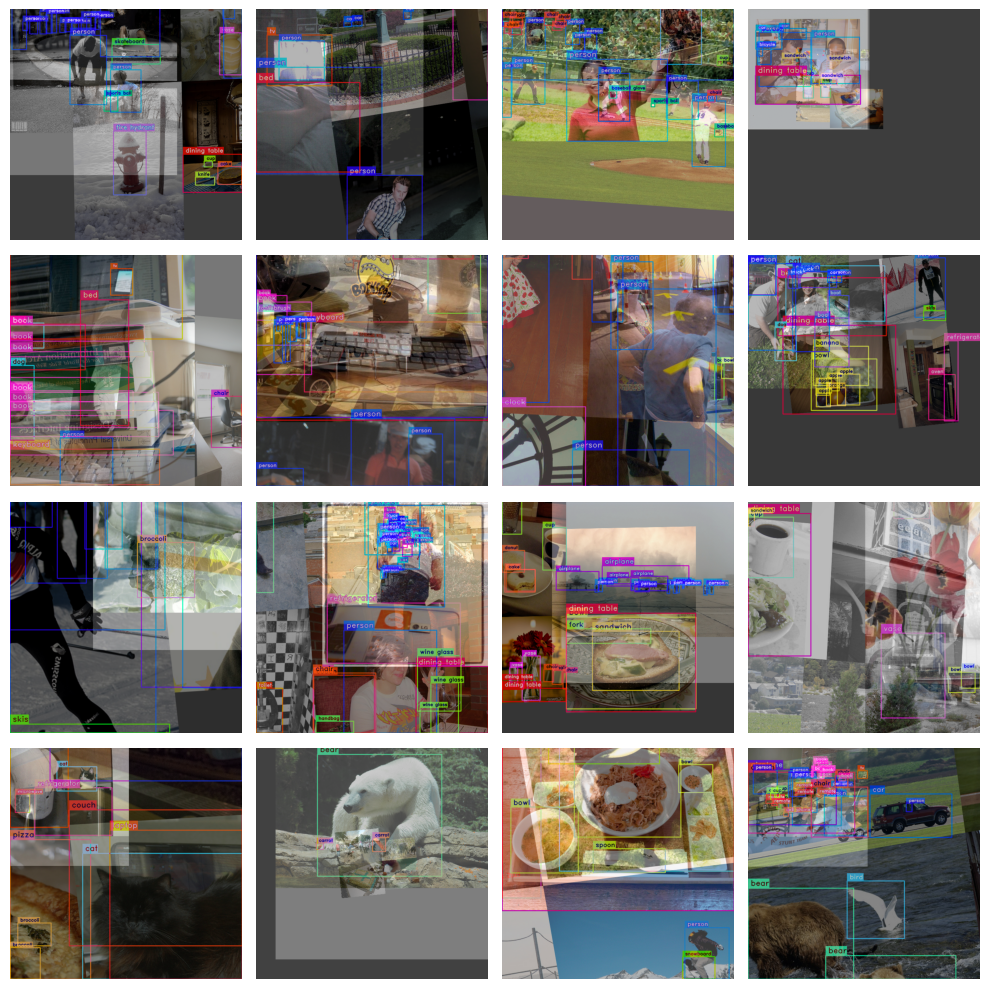

In [30]:
train_data.dataset.plot()

In [ ]:
model = models.get('yolo_nas_s',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="none"
                   )

In [ ]:
train_params = {
    # ENABLING SILENT MODE
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 3,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}


In [ ]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)